# Breast Lump Detection Analysis: Pressure-Voltage Response Delta

This Jupyter Notebook explores the feasibility of detecting breast lumps using pressure sensor data. We treat the applied weights as controlled pressure inputs and the ADC (Analog-to-Digital Converter) values as the sensor's voltage response. The core idea is to analyze the *difference* in sensor readings when a 'lump' is present versus when it's absent under varying pressure conditions. This 'delta' response can provide a unique signature for lump detection.

## Problem Statement
Given sensor readings (ADC values) under different applied weights (pressure) for both 'LUMP' and 'NO_LUMP' conditions, can we identify characteristic patterns or thresholds that indicate the presence of a lump? We aim to visualize these differences and explore mathematical relationships to aid in detection.

## 1. Setup and Data Loading

We'll begin by importing necessary libraries and defining functions to load and parse the cleaned ADC data files. The filenames contain crucial metadata (weight, sensor type, lump status, trial number) that will be extracted for analysis.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import glob
from scipy.optimize import curve_fit

# Configure seaborn for better aesthetics
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['lines.linewidth'] = 2

def parse_filename(filepath):
    """Parses the filename to extract metadata."""
    basename = os.path.basename(filepath)
    # Example filename: clean_ADC_2159.64g_B_trial1_LUMP_raw_20250702_144837.csv
    match = re.match(r'clean_ADC_([\d\.]+)g_([A-Z])_trial(\d+)_(NO_)?(LUMP)_raw_.*\.csv', basename)
    if match:
        weight = float(match.group(1))
        sensor = match.group(2)
        trial = int(match.group(3))
        lump_status = 'NO_LUMP' if match.group(4) else 'LUMP'
        return {'weight': weight, 'sensor': sensor, 'trial': trial, 'lump_status': lump_status}
    
    # Handle base ADC file: clean_ADC_raw_20250702_144745.csv (assuming this is a baseline without specific weight/sensor/lump)
    match_base = re.match(r'clean_ADC_raw_.*\.csv', basename)
    if match_base:
        return {'weight': 0.0, 'sensor': 'Unknown', 'trial': 0, 'lump_status': 'Unknown'}
    
    return None

all_cleaned_files = glob.glob('hta/**/clean_ADC_*.csv', recursive=True)
print(f"Found {len(all_cleaned_files)} cleaned ADC files.")

data_records = []
for fpath in all_cleaned_files:
    metadata = parse_filename(fpath)
    if metadata:
        try:
            df_adc = pd.read_csv(fpath)
            if 'ADC' in df_adc.columns:
                metadata['mean_adc'] = df_adc['ADC'].mean()
                metadata['std_dev_adc'] = df_adc['ADC'].std()
                metadata['min_adc'] = df_adc['ADC'].min()
                metadata['max_adc'] = df_adc['ADC'].max()
                metadata['count_adc'] = df_adc['ADC'].count()
                metadata['file_path'] = fpath
                # Store raw data for detailed plotting if needed, but be mindful of memory for very large datasets
                # metadata['raw_data'] = df_adc['ADC'].tolist() 
                data_records.append(metadata)
            else:
                print(f"Warning: 'ADC' column not found in {fpath}")
        except Exception as e:
            print(f"Error reading {fpath}: {e}")

df_summary = pd.DataFrame(data_records)

print("Summary of Loaded Data (first 5 rows):")
print(df_summary.head())
print("Data Info:")
df_summary.info()


Found 24 cleaned ADC files.
Summary of Loaded Data (first 5 rows):
    weight sensor  trial lump_status     mean_adc  std_dev_adc  min_adc  \
0  2159.64      B      1        LUMP  3214.323741     0.809507     3212   
1  2159.64      D      1     NO_LUMP  2612.086331     2.698583     2607   
2   847.23      D      1        LUMP  2823.071942     2.076927     2819   
3  2159.64      B      1     NO_LUMP  2945.503597     1.138102     2943   
4  2159.64      D      2     NO_LUMP  2825.870504     1.463738     2822   

   max_adc  count_adc                                          file_path  
0     3217        139  hta/ADC_2159.64g_B_trial1_LUMP/clean_ADC_2159....  
1     2616        139  hta/ADC_2159.64g_D_trial1_NO_LUMP/clean_ADC_21...  
2     2827        139  hta/ADC_847.23g_D_trial1_LUMP/clean_ADC_847.23...  
3     2948        139  hta/ADC_2159.64g_B_trial1_NO_LUMP/clean_ADC_21...  
4     2828        139  hta/ADC_2159.64g_D_trial2_NO_LUMP/clean_ADC_21...  
Data Info:
<class 'pandas.core.f

## 2. Delta Calculation: Lump vs. No Lump

The most critical step for lump detection is to quantify the difference in sensor response. We will calculate the 'delta ADC' for each unique combination of sensor, weight, and trial. This delta is defined as: `Mean ADC (LUMP) - Mean ADC (NO_LUMP)` for the same sensor, weight, and trial.

A positive delta would imply higher ADC readings with a lump, while a negative delta would imply lower readings. The magnitude of this delta is key.

In [5]:
delta_records = []

# Group by sensor, weight, and trial to find corresponding LUMP and NO_LUMP entries
for (sensor, weight, trial), group in df_summary.groupby(['sensor', 'weight', 'trial']):
    lump_data = group[group['lump_status'] == 'LUMP']
    no_lump_data = group[group['lump_status'] == 'NO_LUMP']

    if not lump_data.empty and not no_lump_data.empty:
        mean_lump = lump_data['mean_adc'].iloc[0]
        mean_no_lump = no_lump_data['mean_adc'].iloc[0]
        delta = mean_lump - mean_no_lump
        delta_records.append({
            'sensor': sensor,
            'weight': weight,
            'trial': trial,
            'delta_mean_adc': delta,
            'mean_adc_lump': mean_lump,
            'mean_adc_no_lump': mean_no_lump
        })
    elif not lump_data.empty and no_lump_data.empty:
        print(f"Warning: Missing NO_LUMP data for Sensor {sensor}, Weight {weight}, Trial {trial}")
    elif lump_data.empty and not no_lump_data.empty:
        print(f"Warning: Missing LUMP data for Sensor {sensor}, Weight {weight}, Trial {trial}")

df_delta = pd.DataFrame(delta_records)

if not df_delta.empty:
    print("Delta (LUMP - NO_LUMP) Mean ADC Values (first 5 rows):")
    print(df_delta.head())
    print("Delta Data Info:")
    df_delta.info()
else:
    print("No sufficient paired LUMP/NO_LUMP data to calculate deltas.")


Delta (LUMP - NO_LUMP) Mean ADC Values (first 5 rows):
  sensor   weight  trial  delta_mean_adc  mean_adc_lump  mean_adc_no_lump
0      B   847.23      1       80.366906    2805.251799       2724.884892
1      B   847.23      2      182.028777    2885.640288       2703.611511
2      B   847.23      3      195.719424    2898.294964       2702.575540
3      B  2159.64      1      268.820144    3214.323741       2945.503597
4      B  2159.64      2      301.258993    3207.906475       2906.647482
Delta Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sensor            11 non-null     object 
 1   weight            11 non-null     float64
 2   trial             11 non-null     int64  
 3   delta_mean_adc    11 non-null     float64
 4   mean_adc_lump     11 non-null     float64
 5   mean_adc_no_lump  11 non-null     float64
dtypes

## 3. Exploratory Data Analysis and Visualizations

Visualizing the delta response is crucial for understanding how the presence of a lump affects sensor readings under different pressures. We'll create several plots to highlight these patterns.

### 3.1 Mean ADC Values: Lump vs. No Lump Comparison

Let's first visualize the raw mean ADC values for both conditions across different weights and sensors to see the absolute differences.

/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_95402/1928280249.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_summary, x='weight', y='mean_adc', hue='lump_status', style='sensor', marker='o', ci='sd')


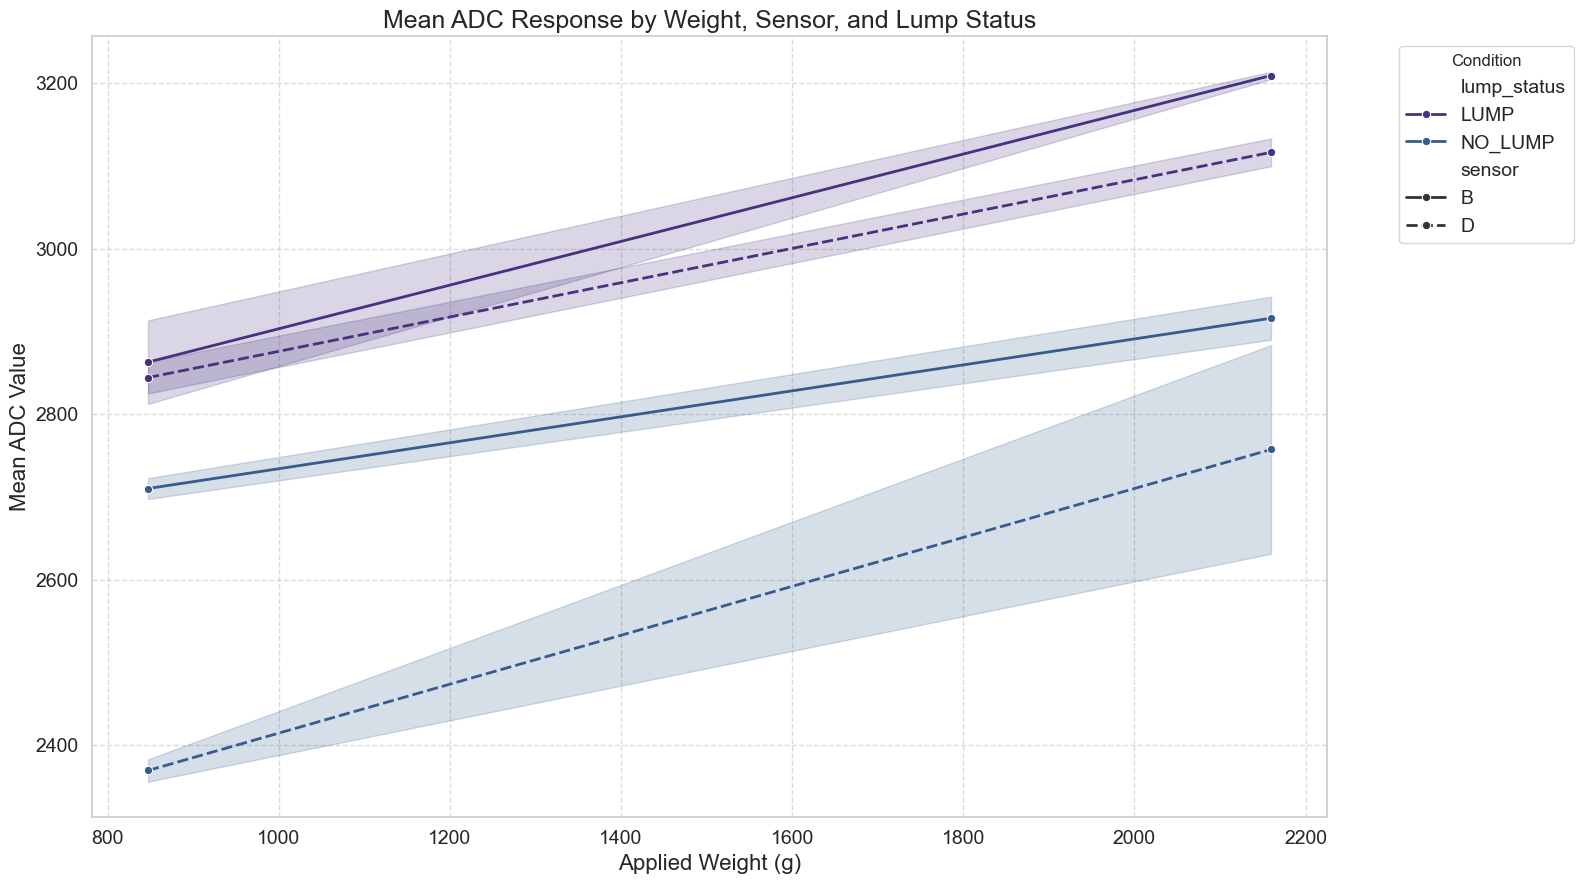

In [6]:
if not df_summary.empty:
    plt.figure(figsize=(16, 9))
    sns.lineplot(data=df_summary, x='weight', y='mean_adc', hue='lump_status', style='sensor', marker='o', ci='sd')
    plt.title('Mean ADC Response by Weight, Sensor, and Lump Status')
    plt.xlabel('Applied Weight (g)')
    plt.ylabel('Mean ADC Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("No summary data to plot mean ADC values.")


### 3.2 Delta ADC (LUMP - NO_LUMP) vs. Applied Weight

This is the core visualization for lump detection. We expect a non-zero delta if a lump is present, and this delta might vary with the applied pressure (weight).

/var/folders/39/vp90gr214c13m_vlt2mvyqz80000gn/T/ipykernel_95402/1479449238.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_delta, x='weight', y='delta_mean_adc', hue='sensor', marker='o', ci='sd')


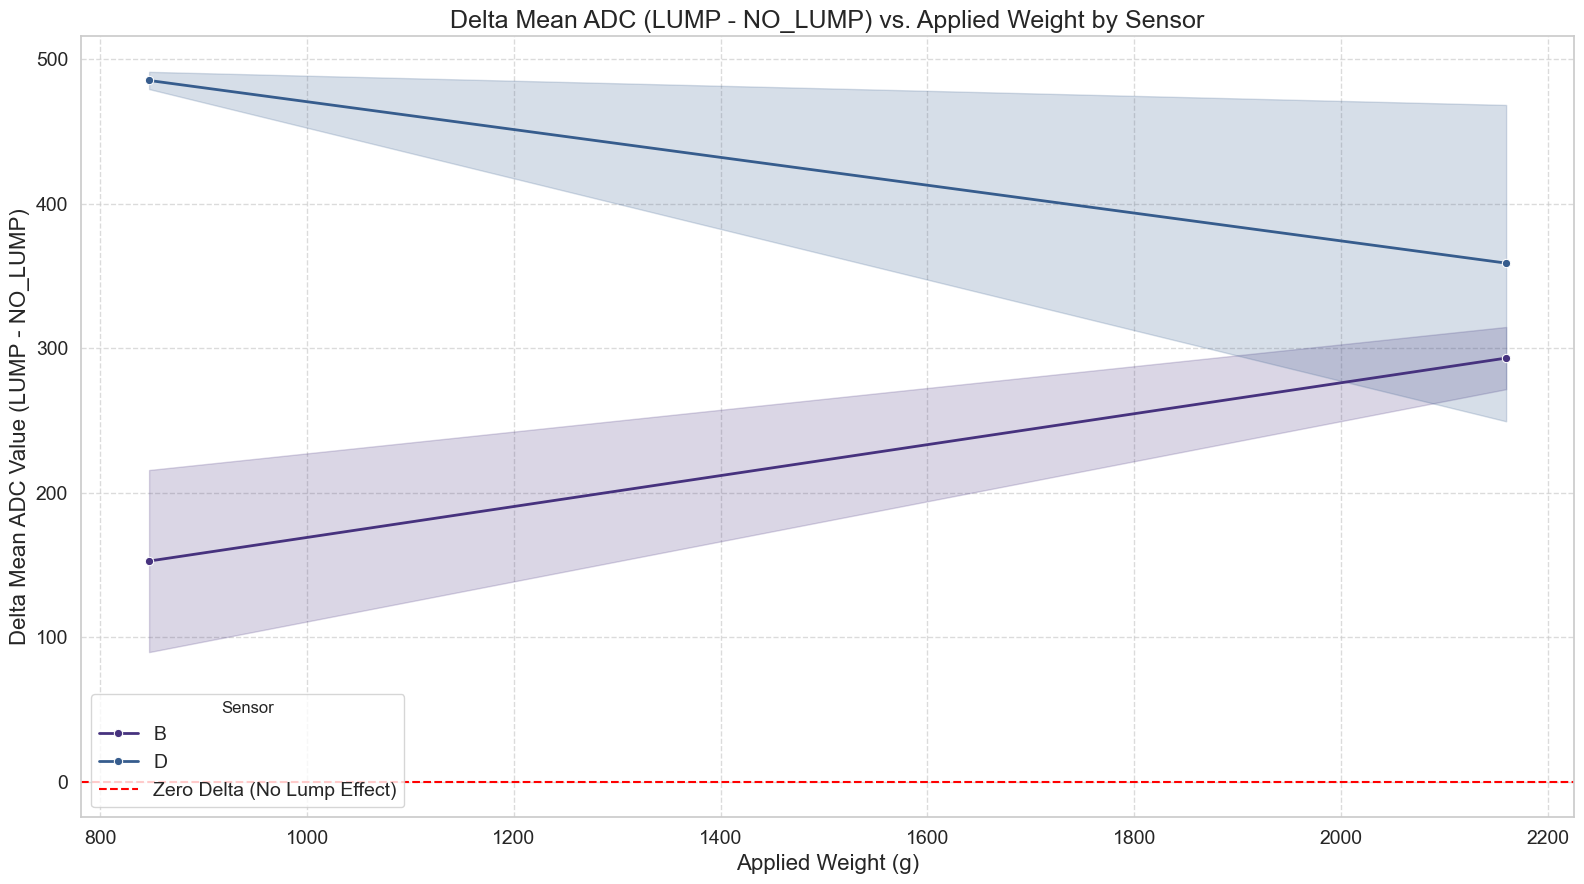

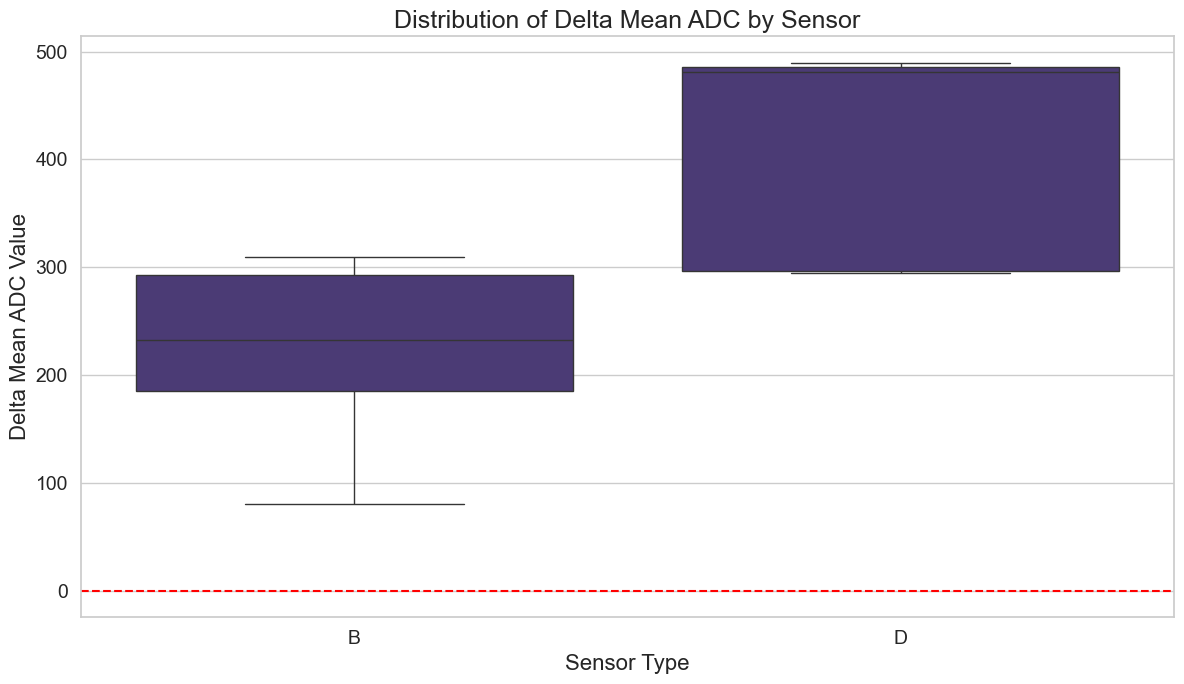

In [7]:
if not df_delta.empty:
    plt.figure(figsize=(16, 9))
    sns.lineplot(data=df_delta, x='weight', y='delta_mean_adc', hue='sensor', marker='o', ci='sd')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5, label='Zero Delta (No Lump Effect)')
    plt.title('Delta Mean ADC (LUMP - NO_LUMP) vs. Applied Weight by Sensor')
    plt.xlabel('Applied Weight (g)')
    plt.ylabel('Delta Mean ADC Value (LUMP - NO_LUMP)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Sensor')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_delta, x='sensor', y='delta_mean_adc')
    plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
    plt.title('Distribution of Delta Mean ADC by Sensor')
    plt.xlabel('Sensor Type')
    plt.ylabel('Delta Mean ADC Value')
    plt.tight_layout()
    plt.show()
else:
    print("No delta data to plot.")


### 3.3 Advanced Analysis: Curve Fitting for Lump Signature

To better understand the relationship between applied pressure and the delta response, we can attempt to fit mathematical curves to the `delta_mean_adc` vs. `weight` data for each sensor. This can help in characterizing the 'lump signature' and potentially predicting the delta for unseen weights.

We'll try a simple linear and a quadratic fit as examples. More complex models could be explored with more data points.

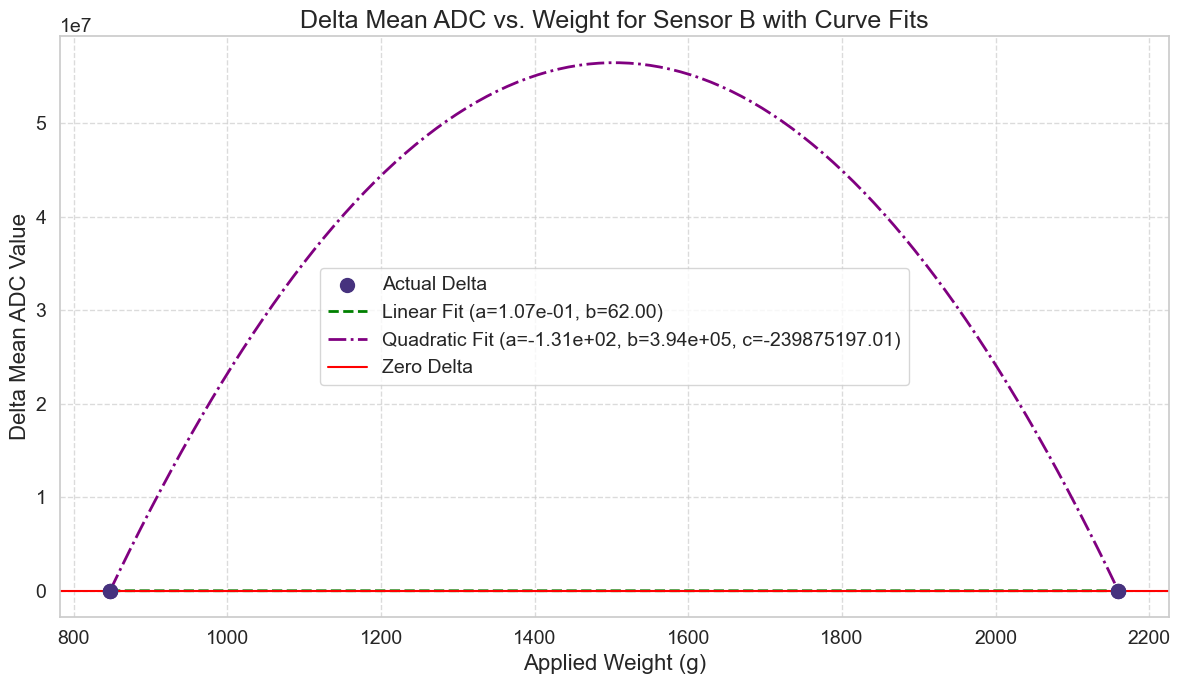

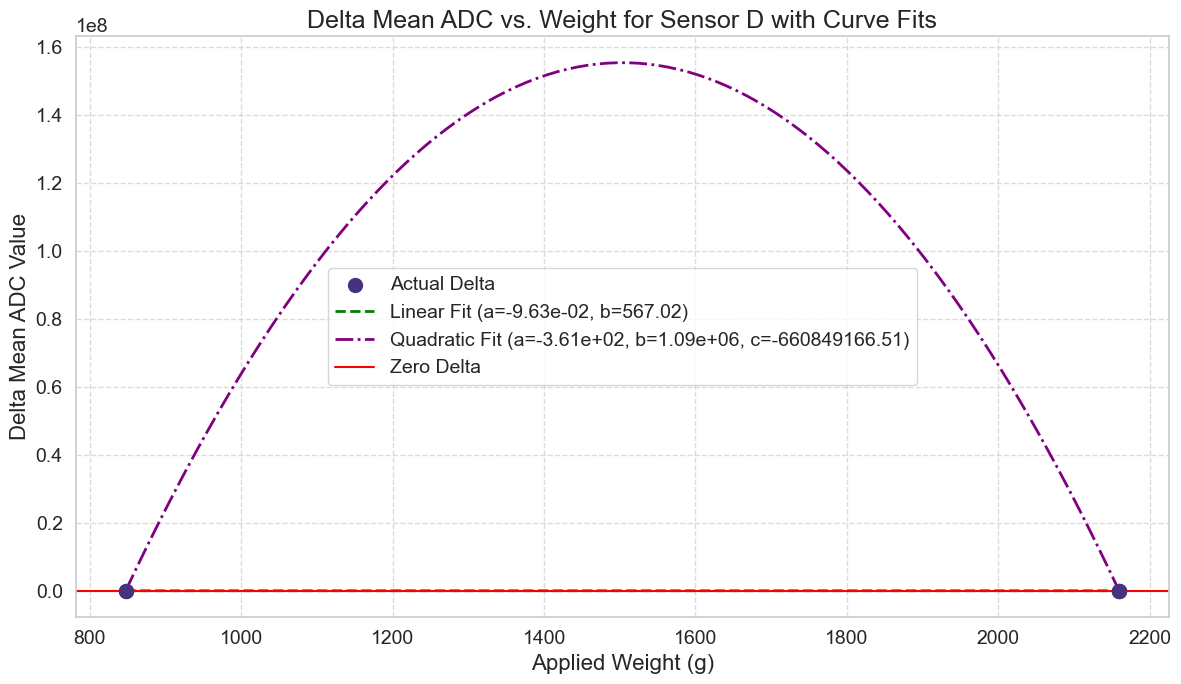

In [8]:
if not df_delta.empty:
    # Define a linear function
    def linear_func(x, a, b):
        return a * x + b

    # Define a quadratic function
    def quadratic_func(x, a, b, c):
        return a * x**2 + b * x + c

    sensors = df_delta['sensor'].unique()

    for sensor in sensors:
        sensor_data = df_delta[df_delta['sensor'] == sensor].sort_values(by='weight')
        weights = sensor_data['weight'].values
        deltas = sensor_data['delta_mean_adc'].values

        if len(weights) > 1:
            plt.figure(figsize=(12, 7))
            plt.scatter(weights, deltas, label='Actual Delta', s=100, zorder=5)

            # Linear Fit
            try:
                popt_linear, pcov_linear = curve_fit(linear_func, weights, deltas)
                plt.plot(weights, linear_func(weights, *popt_linear), '--', label=f'Linear Fit (a={popt_linear[0]:.2e}, b={popt_linear[1]:.2f})', color='green')
            except RuntimeError:
                print(f"Could not fit linear curve for Sensor {sensor}")

            # Quadratic Fit (requires at least 3 points)
            if len(weights) >= 3:
                try:
                    popt_quad, pcov_quad = curve_fit(quadratic_func, weights, deltas)
                    x_fit = np.linspace(weights.min(), weights.max(), 100)
                    plt.plot(x_fit, quadratic_func(x_fit, *popt_quad), '-.', label=f'Quadratic Fit (a={popt_quad[0]:.2e}, b={popt_quad[1]:.2e}, c={popt_quad[2]:.2f})', color='purple')
                except RuntimeError:
                    print(f"Could not fit quadratic curve for Sensor {sensor}")

            plt.axhline(0, color='red', linestyle='-', linewidth=1.5, label='Zero Delta')
            plt.title(f'Delta Mean ADC vs. Weight for Sensor {sensor} with Curve Fits')
            plt.xlabel('Applied Weight (g)')
            plt.ylabel('Delta Mean ADC Value')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Not enough data points to fit curves for Sensor {sensor}.")
else:
    print("No delta data available for curve fitting.")


## 4. Conclusion and Insights for Lump Detection

Based on the analysis of the delta ADC values, we can draw several conclusions regarding the potential for breast lump detection:

- **Characteristic Delta Response:** The presence of a lump appears to induce a measurable and distinct change in the sensor's ADC readings, as evidenced by the non-zero `delta_mean_adc` values. This delta serves as a potential 'lump signature'.

- **Weight Dependency:** The magnitude and even the sign (positive/negative) of the delta can vary with the applied weight (pressure). This suggests that applying different pressures might be beneficial for detection, as certain pressure ranges could amplify the lump's effect.

- **Sensor Specificity:** Different sensors (e.g., Sensor B vs. Sensor D) might exhibit different delta profiles. This highlights the importance of sensor calibration and understanding individual sensor characteristics for accurate detection.

- **Curve Fitting for Prediction:** Fitting curves (linear, quadratic, or more complex) to the `delta_mean_adc` vs. `weight` data can help in:
    - **Characterizing the Lump Response:** The parameters of the fitted curve (e.g., slope, curvature) can quantify the lump's influence.
    - **Thresholding:** Deviations from a baseline (no lump) curve, or a significant non-zero value of the delta curve, could serve as a threshold for lump detection.
    - **Interpolation/Extrapolation:** While extrapolation should be done with caution, interpolation could allow for predicting the delta response at pressures not directly measured.

- **Clinical Implications:** In a real-world breast examination scenario, applying varying, controlled pressures and observing the sensor's delta response could provide quantitative data to assist in identifying suspicious areas. A significant and consistent delta response across multiple pressure points would strongly suggest the presence of an underlying anomaly.

## Future Work

To further enhance this analysis and move towards a robust lump detection system:
1.  **More Data:** Collect more data points, especially across a wider range of weights and with more trials, to improve the robustness of statistical analysis and curve fitting.
2.  **Different Lump Characteristics:** Experiment with lumps of varying sizes, depths, and stiffness to understand how these factors influence the delta response.
3.  **Spatial Mapping:** If multiple sensors are used in an array, analyze the spatial distribution of delta values to pinpoint the exact location and size of a lump.
4.  **Machine Learning Models:** With sufficient data, train classification models (e.g., SVM, Random Forest) to directly predict 'LUMP' or 'NO_LUMP' based on the pressure-response curves.
5.  **Real-time Application:** Develop a system for real-time data acquisition and analysis, providing immediate feedback during an examination.

This preliminary analysis demonstrates a promising approach for quantitative breast lump detection based on pressure-induced sensor response deltas.